
![Image](https://upload.wikimedia.org/wikipedia/en/b/b0/University_of_Akron_seal.svg)
---
# **Enterprise Risk 501 - The University of Akron**
---
## **Monte Carlo Simulation of Financial Data**
 **CASE: Legacy Company Audit**


>Code by Andy Hillier, M.Sc. Accountancy Candidate

---

**ASSIGNMENT**

You have been asked by George Brown, the partner who will be in charge of The Legacy Company audit, to use your analytics skills to assist with planning the audit. George and the audit firm have used Tableau for at least three years and the firm plans to use it in all future audits.  Legacy is a new client. Specifically, George has asked you for assistance with the items listed below.

1.	Prepare a dashboard with appropriate filters to identify any significant trends in Legacy’s performance, with emphasis on its operating return on total assets.

2.	Use the available data to forecast the company’s sales, cost of goods sold, operating expenses (selling, administrative and general expenses—abbreviated as SG&A), and total assets for 2019. Next, compute forecasted operating profit and the forecasted return on total assets for 2019. You may make reasonable assumptions to facilitate building your forecast. Write a brief statement to outline and support each assumption.

3.	You will come up forecasted numbers using your own assumptions for the 3 components that make up operating profit – SALES, COGS, SG&A.

>    You may use the forecasting tool in tableau to test your assumptions and accuracy – this is not a requirement just an extra tool to use if you choose.  You must support your assumptions not just rely on tableau 
>
>    Utilize excel or other method to calculate mean and standard deviation for each of your components of operating profit
>
>    Using your forecasted numbers, mean and standard deviation run a Monte Carlo Simulation in excel to estimate the probability that The Legacy Company will earn the threshold operating return on total assets and not violate its debt covenant.
>
>    Assume Total assets are normally distributed with a mean and standard deviation consistent with the 15 years of data.


4.	Based on your analytics, write a report to George Brown to explain whether there might be a need for the audit team to approach the Legacy audit with a higher or lower level of professional skepticism, particularly in the context of incentives to fraudulently inflate earnings and the return on total assets. Explain your rationale for your conclusion.

---


**MY APPROACH**

I have decided to tackle the issue of data loading, processing/computing, and preparation using python3 with a locally-stored SQLite3 database. SQLite will be used to mount and store the csv data into tables using provided table and column names, connected to python using sqlite3's sqlite3.connect() method, loaded into python via a query executed using sqlite3's cursor.execute() method, collected using the cursor.fetchall() method, processed, and re-stored into a new table within the database.

This SQLite database will then be queried, and the data processed for our simulation. Graphs will be generated using seaborn, a graph plotting module built on top of matplotlib.

The python3 code will be displayed and annotated within this Jupyter notebook's input blocks.
The SQL query data and results will be shown within the output blocks.


---

**Python module import, define functions to load csv data to SQL tables dynamically**

This step involves defining functions for the SQLite database that will allow us to dynamically import csv data into our tables. 

We start by importing all of the modules we will use to perform this simulation. We then define functions for creating a table, generating the table columns from the csv headers, and importing the data by iterating through the csv file row by row.

Create table from csv headers function (**create_table**):
1. Instantiate a cursor to the connection object using the connection.cursor() method
2. Open the data via a locally stored csv file using the open function in read mode ('r')
3. Use the CREATE TABLE IF NOT EXISTS query to see if a table already exists and if not, create a  new table
4. Close the cursor object using the cursor.close() method

Pop table columns from csv headers function (**create_columns**):
1. Instantiate a cursor to the connection object using the connection.cursor() method
2. Open the data via a locally stored csv file using the open function in read mode ('r')
3. Extract the headers, and use ALTER TABLE query to insert each header as a new column by iteration
4. Close the cursor object using the cursor.close() method

Create data loading function (**load_csv_to_table**):
1. Instantiate a cursor to the connection object using the connection.cursor() method
2. Open the data via a locally stored csv file using the open function in write mode ('r')
3. Extract the data less the headers, and use the INSERT INTO ... VALUES query to load cell data for each row by iteration
4. Close the cursor object using the cursor.close() method

In below functions the parameters & variables are as follows:

>**csvp**: The csv file path as a string in memory
>
>**csvf**: csv file as a list of lists in memory
>
>**tblname**: the table name as a string in memory

Finally, all of these functions are combined into a single function (**import_csv**) for fully loading a csv file into a SQL table

In [1]:
#import the sqlite3 library for sql data loading and processing in python3
#import the csv reader module to load project csv file data into python to be stored into SQLite

import sqlite3 as sql
import csv
import time
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#test connection to SQLite
try:
    sqliteConnection = sql.connect('C:\sqlite\MonteCarloProject.db')
    cursor = sqliteConnection.cursor()
    print("Test Connection to SQLite successful!!\n")

    sqlite_select_Query = "select sqlite_version();"
    cursor.execute(sqlite_select_Query)
    record = cursor.fetchall()
    print("SQLite Database Version is: ", record)
    print(f'Jupyter Notebook by Andy Hillier\n\n')
    cursor.close()
    sqliteConnection.close()

except sql.Error as error:
    print("Error while connecting to sqlite", error)

Test Connection to SQLite successful!!

SQLite Database Version is:  [('3.36.0',)]
Jupyter Notebook by Andy Hillier




In [2]:
#define import functions
def create_table(tblname):
    start = time.time()
    cur = sqliteConnection.cursor()
    create_tbl = f'CREATE TABLE IF NOT EXISTS {tblname} (id INTEGER PRIMARY KEY AUTOINCREMENT);' 
    cur.execute(create_tbl)
    print(f'Query Executed: {create_tbl}')
    cur.close()
    end = time.time()
    print(f'Table Created: {tblname}\n')
    print(f'Execution time for {tblname}: {end - start:.20f} seconds\n\n')

def create_columns(csvp, tblname):
    start = time.time()
    cur = sqliteConnection.cursor()
    with open(f'{csvp}', 'r', encoding = 'utf-8') as csvf:
        opened_file = csv.reader(csvf)
        try:
            data = list(opened_file)
            import_data = data[0]
            print(f'IMPORT DATA:\n{import_data}......\n')
            for header in import_data:
                pop_tbl = (f'ALTER TABLE {tblname} ADD COLUMN {header} INTEGER;')
                cur.execute(pop_tbl)
                print(f'Query Executed: {pop_tbl}')
                print(f'Column Created: {header}\n')
        except sql.Error as error:
            print('Error while connecting to sqlite', error)
    cur.close()
    end = time.time()
    print(f'Execution time for {csvp} headers\nto {tblname} table columns: {end - start:.10f} seconds\n\n')

def load_csv_to_table(csvp, tblname):
    start = time.time()
    cur = sqliteConnection.cursor()
    with open(f'{csvp}', 'r', encoding = 'utf-8') as csvf:
        opened_file = csv.reader(csvf)
        try:
            data = list(opened_file)
            import_data = data[1:]
            print(f'IMPORT DATA:\n{import_data[:5]}......\n')
            pk = 0 #Primary Key for 'UNIQUE' constraint. Ensures unique id's for every inserted row
            for row in import_data:
                pk += 1
                pkitem = f'{pk}'
                row.insert(0, pkitem) #insert primary key at the beginning of the row to be passed to table.id
                [int(item) for item in row]
                print(row)
                placeholders = '?, ' * (len(row) - 1) + '?'
                cur.executemany(f'INSERT INTO {tblname} VALUES ({placeholders});', (row,))
            print(f'Query Executed: INSERT INTO {tblname} VALUES ({placeholders});')
            print(f'Inserted {pk} rows into {tblname}\n')
        except sql.Error as error:
            print('Error while connecting to sqlite', error)
    cur.close()
    end = time.time()
    print(f'Execution time for CSV Load from {csvp} to {tblname}: {end - start:.5f} seconds\n\n')

def import_csv(csvp, tblname):
    print(f'!START IMPORT PROCESS!: \n\n')
    start = time.time()
    create_table(tblname)
    create_columns(csvp, tblname)
    load_csv_to_table(csvp, tblname)
    end = time.time()
    print(f'Total execution time for CSV import from {csvp} into {tblname}: {end - start:.5f} seconds\n')


**Upload CSV Files to SQLite**

In this step, we use the above functions to dynamically import our financial data from Legacy company. The data we ere provided were the Summary of Operating Income, the Summary Balance Sheet, and the Statement of Cash Flows. 

Although we may not use all of this data, due to the small file size we will upload all of it. If we had decided to use historical data from any of these tables for forecasting other than our profit, such as in a multiple linear regression, the data would be available then in SQLite to query.

We define our file paths and desired table names to pass into the above-described **csvp** and **tblname** parameters of our **csv_import** function by first storing them as variables, then calling the function with the stored variables.

>Within our output block, we can see each SQL query dynamically passed as we intended it to in our above-defined functions, as well as the execution times. Execution times are useful for SQL queries while working from a python environment, as we can analyze actual query processing speed without needing to call EXPLAIN ANALYZE on the query and rolling it back.
>
>By using placeholders and mogrifying row values, we can avoid SQL injections as a threat. Note that there is still a vulnerability open via the table and column names - this was left there intentionally as we are not worried about any threats to hacking for this assignment, but under other circumstances we could use sql.SQL() for composing the query and sql.Indentifier()/sql.Literal() to properly annotate all query parameters, saving us from that risk. 
>
>SQLite may have more limited options than say, SSRS or PostgreSQL, but as a file on our windows filesystem, we could also secure any access to this file via windows administrative permissions to ensure only approved users can connect to it.

In [3]:
#our code to import our csv files using the above defined functions

#file paths to the database and the data we want to pass into python to load into our SQLite3 database
database_path = 'C:\sqlite\MonteCarloProject.db'

summary_operating_income = 'C:\LocalDataFiles\LegacyAudit\SummaryOperatingIncome.csv'
sum_op_tbl = 'summary_operating_income'

summary_balance_sheet = 'C:\LocalDataFiles\LegacyAudit\SummaryBalanceSheet.csv'
sum_bal_tbl = 'summary_balance_sheet'

statement_of_cash_flows = 'C:\LocalDataFiles\LegacyAudit\StatementOfCashFlows.csv'
stmt_cash_tbl = 'statement_of_cash_flows'

#execute our loading function for each of our CSV files
try:
    sqliteConnection = sql.connect(database_path)
    cursor = sqliteConnection.cursor()
    print("Successfully Connected to SQLite")

    sqlite_select_Query = "select sqlite_version();"
    cursor.execute(sqlite_select_Query)
    record = cursor.fetchall()
    print("SQLite Database Version is: ", record)
    print("Module: import CSV into SQLite\n---\n")
    cursor.close()
    
    #Import Columns for summary operating income data:
    import_csv(summary_operating_income, sum_op_tbl)

    #Import Columns for summary balance sheet data:
    import_csv(summary_balance_sheet, sum_bal_tbl)

    #Import Columns for statement of cash flows data:
    import_csv(statement_of_cash_flows, stmt_cash_tbl)
    
    sqliteConnection.commit()
    sqliteConnection.close()
    
except sql.Error as error:
    print("Error while connecting to sqlite", error)
    
finally:
    if (sqliteConnection):
        sqliteConnection.close()
        print("\n---\nThe SQLite connection is closed.")


Successfully Connected to SQLite
SQLite Database Version is:  [('3.36.0',)]
Module: import CSV into SQLite
---

!START IMPORT PROCESS!: 


Query Executed: CREATE TABLE IF NOT EXISTS summary_operating_income (id INTEGER PRIMARY KEY AUTOINCREMENT);
Table Created: summary_operating_income

Execution time for summary_operating_income: 0.01599860191345214844 seconds


IMPORT DATA:
['Year', 'NetSales', 'CostOfGoodsSold', 'GrossProfit', 'SellingAdministrativeGeneralExpenses', 'OperatingIncome']......

Query Executed: ALTER TABLE summary_operating_income ADD COLUMN Year INTEGER;
Column Created: Year

Query Executed: ALTER TABLE summary_operating_income ADD COLUMN NetSales INTEGER;
Column Created: NetSales

Query Executed: ALTER TABLE summary_operating_income ADD COLUMN CostOfGoodsSold INTEGER;
Column Created: CostOfGoodsSold

Query Executed: ALTER TABLE summary_operating_income ADD COLUMN GrossProfit INTEGER;
Column Created: GrossProfit

Query Executed: ALTER TABLE summary_operating_income ADD

**Query data from SQL needed for forecast, store as lists in memory**

In this step we define a function to query columns from our new SQLite tables, and store the queried data into variables as lists: (**extract_columns_to_lists**). 

Our goal for this simulation is to calculate the Return on Total Assets, so we will need to pull **Revenue**, **COGS**, and **SG&A**  from the Summary of Operating Income (Income Statement) in order to find our profit (revenues less expenses), and **Total Assets** from the Summary Balance Sheet. We do this using a SELECT column_name FROM tablename SQL query.

We also pull the **Years** column from Summary Balance sheet, but we could actually retrieve this data from any of our tables. As all of the tables contain rows for the same amount of years (2004 - 2018), we will not need to adjust our queries for a specific time period.

As seen in the output block, we now have lists containing our historical financial data stored into memory in python, which we can call via their variables for our analysis.

In [4]:
#define function to extract columns - variable must be instantiated with name as string
#after the function is run, lists are contained within 'var', which should be stored in the variable
def extract_columns_to_lists(col, tbl, v_name):
    global var
    var = v_name
    print(f'Variable to store list: {var}')
    cursor.execute(f"""
        SELECT {col}
        FROM {tbl}; 
    """)
    var = cursor.fetchall()
    print(f'Column Extracted to List: {col}\n{var}\n')

#query the data from 2004 - 2018 for revenue, cogs, sg&a, and assets
try:
        sqliteConnection = sql.connect(database_path)
        cursor = sqliteConnection.cursor()
        print("Successfully Connected to SQLite")

        sqlite_select_Query = "select sqlite_version();"
        cursor.execute(sqlite_select_Query)
        record = cursor.fetchall()
        print("SQLite Database Version is: ", record)
        print("Module: Extract Column Data from SQLite\n---\n")
        
        v_name = 'y_rev'
        #extract revenue column as list
        extract_columns_to_lists('NetSales', 'summary_operating_income', v_name)
        #assign list to variable
        y_rev = var

        v_name = 'y_cogs'
        #extract COGS column as list
        extract_columns_to_lists('CostOfGoodsSold', 'summary_operating_income', v_name)
        #assign list to variable
        y_cogs = var
        
        v_name = 'y_sga'
        #extract SG&A column as list
        extract_columns_to_lists('SellingAdministrativeGeneralExpenses', 'summary_operating_income', v_name)
        #assign list to variable
        y_sga = var

        v_name = 'y_assets'
        #extract total assets column as list
        extract_columns_to_lists('TotalAssets', 'summary_balance_sheet', v_name)
        #assign list to variable
        y_assets = var

        v_name = 'x_time'
        #extract year column as list
        extract_columns_to_lists('Year', 'summary_balance_sheet', v_name)
        #assign list to variable
        x_time = var
        
        var = None
        
        cursor.close()
        sqliteConnection.commit()
        sqliteConnection.close()
    
except sql.Error as error:
        print("Error while connecting to sqlite", error)

finally:
    if (sqliteConnection):
        sqliteConnection.close()
        print("\n---\nThe SQLite connection is closed.")
    

Successfully Connected to SQLite
SQLite Database Version is:  [('3.36.0',)]
Module: Extract Column Data from SQLite
---

Variable to store list: y_rev
Column Extracted to List: NetSales
[(7737500,), (7688500,), (7579000,), (8221500,), (9069000,), (9770000,), (10496000,), (11383500,), (9416000,), (8150500,), (9744000,), (9822000,), (10129000,), (9861500,), (9185200,)]

Variable to store list: y_cogs
Column Extracted to List: CostOfGoodsSold
[(5980500,), (5859500,), (5486000,), (6082000,), (6953000,), (7711000,), (8581500,), (9410500,), (7726000,), (6838000,), (8069500,), (7960000,), (8503000,), (7886000,), (7354600,)]

Variable to store list: y_sga
Column Extracted to List: SellingAdministrativeGeneralExpenses
[(1156000,), (1151000,), (1203500,), (1307000,), (1360000,), (1379000,), (1359000,), (1411000,), (1315000,), (1202000,), (1300000,), (1381000,), (1335500,), (1437500,), (1416550,)]

Variable to store list: y_assets
Column Extracted to List: TotalAssets
[(8436000,), (8532000,), (82

**Create function for and perform linear regression & forecast; Store data as list of lists in memory**

In this step, we define a function to perform a linear regression using points generated from our income statement and total assets data previously stored into variables as well as our list of years.

We convert these lists to numpy array objects in order to perform the analysis. We then use scikitLearn's **sklearn.linear_model.LinearRegression(**) function, with our newly generated arrays passed in to fit a line to our data. We also use **LinearRegression.Predict()** method with our time data to predict the y-intercepts on our fitted line for each year in our analysis.

Additionally, we use the numpy array objects to calculate the **mean**, **standard deviation**, **slope**, **trendline equation**, and a **prediction for 2019's y-intercept** along the calculated trendline using np.mean(), np.std(), and simple linear equations.

Within the function, we also store our linear regression data calculated above into a list of lists (**LinReg_Data**) to be used for our Monte Carlo Simulation.

***Revenue Simple Regression Analysis - Prediction for 2019***

Predicted Trend b-values (2004 to 2018):

[[ 8216132.5       ]
 [ 8359096.4285714 ]
 [ 8502060.35714287]
 [ 8645024.28571427]
 [ 8787988.21428573]
 [ 8930952.14285713]
 [ 9073916.07142854]
 [ 9216880.        ]
 [ 9359843.9285714 ]
 [ 9502807.85714287]
 [ 9645771.78571427]
 [ 9788735.71428573]
 [ 9931699.64285713]
 [10074663.57142854]
 [10217627.5       ]]

Equation of Trend Line:

y = [-6.99477141e-06]*x + b

Coefficient of Determination (R^2):
0.32

Coefficient of Variation:
11.86

Prediction for 2019:
$ 8,073,168

Mean from available data:
~9,216,880

Standard Deviation from available data:
~1,093,175



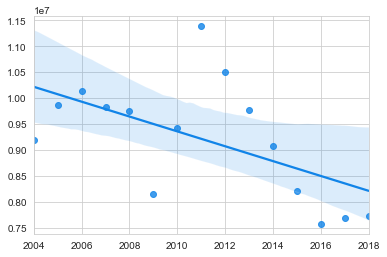



***COGS Simple Regression Analysis - Prediction for 2019***

Predicted Trend b-values (2004 to 2018):

[[6232005.83333331]
 [6393158.33333331]
 [6554310.83333331]
 [6715463.33333331]
 [6876615.83333331]
 [7037768.33333331]
 [7198920.83333331]
 [7360073.33333331]
 [7521225.83333331]
 [7682378.33333331]
 [7843530.83333331]
 [8004683.33333331]
 [8165835.83333331]
 [8326988.33333331]
 [8488140.83333331]]

Equation of Trend Line:

y = [-6.20530243e-06]*x + b

Coefficient of Determination (R^2):
0.40

Coefficient of Variation:
14.94

Prediction for 2019:
$ 6,070,853

Mean from available data:
~7,360,073

Standard Deviation from available data:
~1,099,640



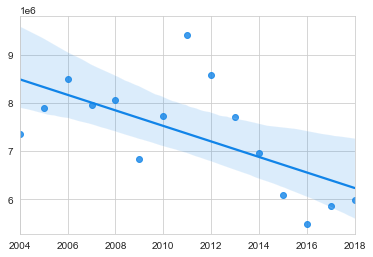



***SGA Simple Regression Analysis - Prediction for 2019***

Predicted Trend b-values (2004 to 2018):

[[1216248.75      ]
 [1230251.78571429]
 [1244254.82142857]
 [1258257.85714286]
 [1272260.89285714]
 [1286263.92857143]
 [1300266.96428572]
 [1314270.        ]
 [1328273.03571429]
 [1342276.07142857]
 [1356279.10714286]
 [1370282.14285714]
 [1384285.17857143]
 [1398288.21428572]
 [1412291.25      ]]

Equation of Trend Line:

y = [-7.14130864e-05]*x + b

Coefficient of Determination (R^2):
0.44

Coefficient of Variation:
6.95

Prediction for 2019:
$ 1,202,245

Mean from available data:
~1,314,270

Standard Deviation from available data:
~91,297



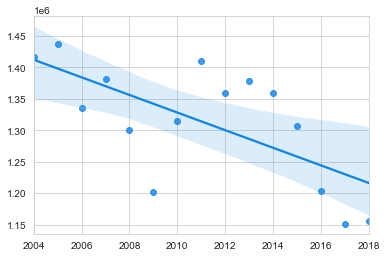



***Total Assets Simple Regression Analysis - Prediction for 2019***

Predicted Trend b-values (2004 to 2018):

[[8562604.58333333]
 [8523995.83333333]
 [8485387.08333333]
 [8446778.33333333]
 [8408169.58333333]
 [8369560.83333333]
 [8330952.08333333]
 [8292343.33333333]
 [8253734.58333333]
 [8215125.83333333]
 [8176517.08333333]
 [8137908.33333333]
 [8099299.58333333]
 [8060690.83333333]
 [8022082.08333333]]

Equation of Trend Line:

y = [2.59008644e-05]*x + b

Coefficient of Determination (R^2):
0.12

Coefficient of Variation:
5.78

Prediction for 2019:
$ 8,601,213

Mean from available data:
~8,292,343

Standard Deviation from available data:
~478,946



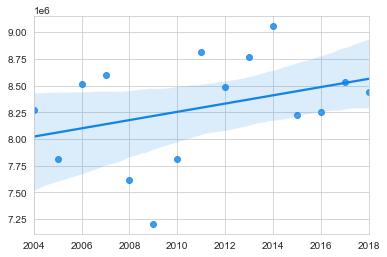



Data Output [slope, std_dev, y_2019]:

[[array([-6.99477141e-06]), 9216880.0, 1093175.3602540933, array([8073168.55730609])], [array([-6.20530243e-06]), 7360073.333333333, 1099640.163245333, array([6070853.32080481])], [array([-7.14130864e-05]), 1314270.0, 91297.00944353727, array([1202245.57010269])], [array([2.59008644e-05]), 8292343.333333333, 478946.0724224481, array([8601213.38562717])]]



In [5]:
#initialize an empty list to store run data
LinReg_Data = []

#define linear regression and prediction function
def LinReg_PDCT2019(x, y):
    xlr = np.array(x)
    xlr = xlr.reshape(-1, 1)
    ylr = np.array(y)
    
    #perform the simple linear regression
    linreg = LinearRegression().fit(xlr,ylr)
    b = linreg.predict(xlr)
    print(f'\nPredicted Trend b-values (2004 to 2018):\n\n{b}\n')
    
    #slope is 'rise over run' -- 'rise' is 1 year, so slope is equivalent to the run
    slope = 1 / (b[13] - b[14])
    print(f'Equation of Trend Line:\n\ny = {slope}*x + b\n')
    
    #determine the 'fit' correlation
    R2_var = linreg.score(xlr,ylr)
    print(f'Coefficient of Determination (R^2):\n{R2_var:.2f}\n')
    
    #determine the variance
    coef_var = (np.std(ylr)*100) / np.mean(ylr)
    print(f'Coefficient of Variation:\n{coef_var:.2f}\n')
    
    #use the linear equation to predict 2019's y_value
    x_2019 = 2019
    b_2019 = b[0] + (b[13] - b[14])
    y_2019 = (slope * x_2019) + b_2019
    print(f'Prediction for 2019:\n$ {int(y_2019):,.0f}\n')
    
    #calculate the mean
    mean = np.mean(ylr)
    print(f'Mean from available data:\n~{mean:,.0f}\n')
    
    #calculate the standard deviation
    std_dev = np.std(ylr)
    print(f'Standard Deviation from available data:\n~{std_dev:,.0f}\n')
    
    #store values needed for montecarlosim
    LinReg_Data.append([slope, mean, std_dev, y_2019])
    
    #plot regression output via matplotlib/seaborn
    sns.set_style('whitegrid')
    sns.regplot(
        x = xlr, 
        y = ylr, 
        color = '#1184e8'
    )
    plt.show()
    print(f'\n')
    
#run analyses by inputting variables previously stored
print(f'***Revenue Simple Regression Analysis - Prediction for 2019***')
LinReg_PDCT2019(x_time, y_rev)
print(f'***COGS Simple Regression Analysis - Prediction for 2019***')
LinReg_PDCT2019(x_time, y_cogs)
print(f'***SGA Simple Regression Analysis - Prediction for 2019***')
LinReg_PDCT2019(x_time, y_sga)
print(f'***Total Assets Simple Regression Analysis - Prediction for 2019***')
LinReg_PDCT2019(x_time, y_assets)

print(f'Data Output [slope, std_dev, y_2019]:\n\n{LinReg_Data}\n')

**Perform Monte Carlo Simulation & Plot Results**

In this step, we assume that the probability distribution of the simulated results is similar to a bell curve.
For this reason, we take advantage of the numpy module's **np.random.normal()** method, which generates a random result
with the provided forcasted value from our linear regression, within the calculated standard deviation, assuming a
'normal' probability distribution. We calculate this for each account by iterating through out **LinReg_Data** list generated during our linear regression analysis.

numpy documentation on **np.random.normal()** can be found here:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html

For the function to be a Monte Carlo simulation, we specify a large number of trials to run (**num_reps**)
and store those randomly-generated values (numpy array objects) into an empty list (**mclist**). We then will perform summary
statistics on these list items to generate probability data.

the following was pulled from https://www.palisade.com/risk/monte_carlo_simulation.asp

>Monte Carlo simulation is a computerized mathematical technique that allows people to account for risk in quantitative analysis and decision making. The technique is used by professionals in such widely disparate fields as finance, project management, energy, manufacturing, engineering, research and development, insurance, oil & gas, transportation, and the environment.
>
>Monte Carlo simulation furnishes the decision-maker with a range of possible outcomes and the probabilities they will occur for any choice of action. It shows the extreme possibilities—the outcomes of going for broke and for the most conservative decision—along with all possible consequences for middle-of-the-road decisions.
>
>Monte Carlo simulation performs risk analysis by building models of possible results by substituting a range of values—a probability distribution—for any factor that has inherent uncertainty. It then calculates results over and over, each time using a different set of random values from the probability functions. Depending upon the number of uncertainties and the ranges specified for them, a Monte Carlo simulation could involve thousands or tens of thousands of recalculations before it is complete. Monte Carlo simulation produces distributions of possible outcome values.
>
>By using probability distributions, variables can have different probabilities of different outcomes occurring. Probability distributions are a much more realistic way of describing uncertainty in variables of a risk analysis. 

We then iterate through each item to categorize them into 'bins' or 'buckets' of percentages, and display those counts
in a histogram generated using seaborn. As you can see below, this histogram shows a normal distribution, and shows that a 
large amount of the results could potentially occur under 8%, meaning that Legacy Company has a relatively large chance of
violating its debt covenants.

This is also supported by the summary statistics, which show that **the probability of the return on total assets being less than 8%**, given our forcasted Revenues, COGS (cost of goods sold), SG&A (Selling, General, and Administartive Expenses), and Total Assets, **is a little over 50%**.

Simulated Revenue Values:

[8961198.98601992, 8056171.525843842, 7271087.198243837, 7831786.769868599, 9797213.305317737]
...
[6989611.8919727765, 8006704.795216977, 9711886.81740627, 8268727.096610529, 9863162.657542814]

Count: 50,000 randomly generated items


Simulated COGS Values:

[5477674.522452039, 5135146.13609957, 6782074.310344992, 8255548.79168582, 5726663.528616823]
...
[7098172.082343821, 4824223.874745912, 6630506.208930785, 6923097.777045473, 6752469.405539148]

Count: 50,000 randomly generated items


Simulated Selling, General, and Admin Expenses Values:

[1380143.6909322615, 1123302.8259273965, 1179154.429090213, 1266647.272597188, 1216297.819747698]
...
[1147374.005491005, 1325339.1444924425, 1191361.7039368758, 1053257.8963899359, 905178.0636572326]

Count: 50,000 randomly generated items


Simulated Total Assets Values:

[8292916.477031826, 8102701.859914234, 9097739.34715485, 8077749.713757833, 9242019.36512143]
...
[8444131.788030637, 8769480.819126107, 8974690.

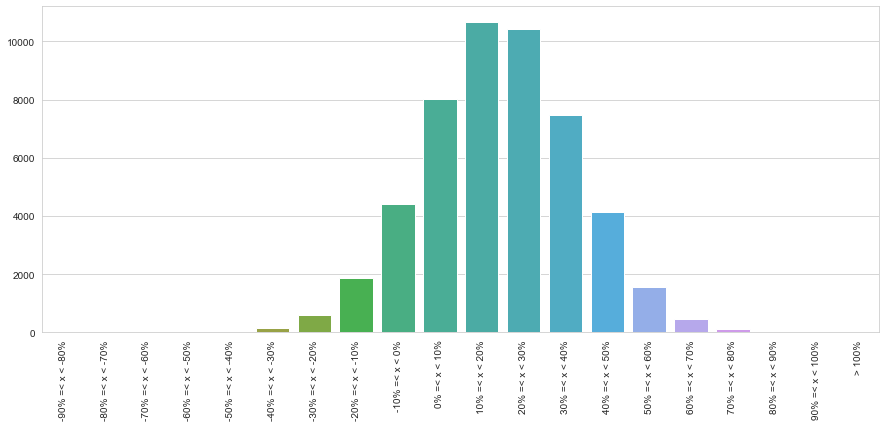

In [6]:
#creae function per above markup block
def MonteCarloSim(data, empty_list):
    num_reps = 50000
    num_simulations = 1
    for row in data:
        mn = row[1]
        fcst = row[3]
        std_dev = row[2]
        for row in range(0, num_simulations):
            pct_to_target = np.random.normal(fcst, std_dev, num_reps) #Normal Distro
            row = pct_to_target
            empty_list.append(row)
    return empty_list

#instantiate empty list object to collect results, perform MonteCarlo sim on data, convert array outputs to lists
mclist = []
MonteCarloSim(LinReg_Data, mclist)
l = [arr.tolist() for arr in mclist]

#generate information on output
for item in l:
    if item == l[0]:
        item_name = 'Revenue'
    elif item == l[1]:
        item_name = 'COGS'
    elif item == l[2]:
        item_name = 'Selling, General, and Admin Expenses'
    elif item == l[3]:
        item_name = 'Total Assets'
    print(f'Simulated {item_name} Values:\n\n{item[:5]}\n...\n{item[-5:]}\n\nCount: {len(item):,} randomly generated items\n\n')

#convert lists to numpy martices for matrix mathematical operations
rev = np.matrix(l[0])
cogs = np.matrix(l[1])
sga = np.matrix(l[2])
assets = np.matrix(l[3])

print(f'Converted generated simulation results to matrices for mataematical operations\n\n')

#calculate Return on Total Assets
return_on_total_assets = (rev - cogs - sga) / assets

print(f'Created "return on total assets":\n\nObject of type: {type(return_on_total_assets)}\nreturn on total assets =\n(matrix(rev) - matrix(cogs) - matrix(sga)) / matrix(assets)')

#Convert Return on Total Assets to numpy array, calculate mean and std dev of return, and then convert back to list
return_on_total_assets = np.array(return_on_total_assets)
print(f'\nmean: {np.mean(return_on_total_assets):.2f}, std_dev: {np.std(return_on_total_assets):.2f}\n\nConverted Return on Total Assets to array, then list')
return_on_total_assets = [arr.tolist() for arr in return_on_total_assets]

#Count results, and count results falling within specified 'bins'
val_div = [-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
bins = [0 for _ in range(len(val_div)+1)]
for v in return_on_total_assets[0]:
    if v > val_div[-1]:
        bins[-1] += 1
    else:
        k = 0
        while v > val_div[k]:
            k += 1
        bins[k] += 1
abv_100_pct = bins[-1]
blw_n100_pct = bins[0]
bins = bins[1:-1]
labels = ['-90% =< x < -80%',
          '-80% =< x < -70%',
          '-70% =< x < -60%',
          '-60% =< x < -50%',
          '-50% =< x < -40%',
          '-40% =< x < -30%',
          '-30% =< x < -20%',
          '-20% =< x < -10%',
          '-10% =< x < 0%',
          '0% =< x < 10%',
          '10% =< x < 20%',
          '20% =< x < 30%',
          '30% =< x < 40%',
          '40% =< x < 50%',
          '50% =< x < 60%',
          '60% =< x < 70%',
          '70% =< x < 80%',
          '80% =< x < 90%',
          '90% =< x < 100%',
          '> 100%']

#Calculate the probablity that an item in the list is greater than 8% (how many items out of 50,000 are >0.08?)
prob_greater_8 = []
for sim in return_on_total_assets[0]:
    if sim >= 0.08:
            prob_greater_8.append(sim)

print(f'\nNumber of Return on Total Assets results (out of 50,000) greater than 8%:\n{len(prob_greater_8):,}')
print(f'\nProbability simultation result is > 8%:\n{((len(prob_greater_8) / 50000)*100):.2f}%\n\n')

#Generate Histogram per above defined labels and bins with simulation results
print(f'Histogram: Count of Simulated Percentages for Return on Total Assets (%)')
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(
    x = labels,
    y = bins,
    ax = ax
)
plt.xticks(rotation=90)
plt.show()


**Error Analysis**

It is likely that our results could come out differently as a result of several variables within our simulations.
For one, our forecasted Profit and Assets could be inaccurate. For this exercise we used a simple linear regression utilizing historical data, but other variables could have been taken into consideration that represent the industry as a whole, such as a market-wide increases or decreases in the value of services or products sold by Legacy Company. 
We could have taken several variables and performed a multiple linear regression to more accurately reflect the local & industry-wide markets, or used bottom-up analytical data such as website traffic statistics or recent sales numbers in order
to adjust our forcast.

Additionally, we could have made extra assumptions about the probablility distribution of the data. A uniform or lognormal probability distribution may be more suitable for the various accounts, although this would likely need ot be determined by a subject matter expert, such as an economist or mathemetician who is familiar with econometric modeling.


# **Tool: Drop SQL Tables**

This tool is used to 'reset' the SQLite database, so the earlier input blocks may be re-run without error for testing.

In [ ]:
try:
    sqliteConnection = sql.connect('C:\sqlite\MonteCarloProject.db')
    cursor = sqliteConnection.cursor()
    print("Successfully Connected to SQLite")
    
    print("Please enter the name of the table to drop:")
    tblname = input()
    
    try:
        cursor.execute('DROP TABLE IF EXISTS {};'.format(tblname))
        print('\n\nQuery Executed: DROP TABLE IF EXISTS {};'.format(tblname))
        print('Dropped {}\n\n'.format(tblname))
        
        cursor.execute('DROP TABLE IF EXISTS summary_operating_income;')
        print(f'Query Executed: DROP TABLE IF EXISTS statement_of_cash_flows;')
        print('Dropped summary_operating_income\n\n')
        
        cursor.execute('DROP TABLE IF EXISTS summary_balance_sheet;')
        print(f'Query Executed: DROP TABLE IF EXISTS statement_of_cash_flows;')
        print('Dropped summary_balance_sheet\n\n')
        
        cursor.execute('DROP TABLE IF EXISTS statement_of_cash_flows;')
        print(f'Query Executed: DROP TABLE IF EXISTS statement_of_cash_flows;')
        print('Dropped statement_of_cash_flows\n\n')
        
    except sql.Error as error:
        print('Error while connecting to sqlite', error)
    
except sql.Error as error:
    print('Error while connecting to sqlite', error)